In [1]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

/Users/raviagrawal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/raviagrawal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# This variable will be used for the feature selection

In [2]:
k = 5

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData, X_train, X_test, y_train, y_test, title="confusion matrix"):
    # Fitting the training data
    clf.fit(X_train, y_train)
    
    # Predicting the data
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    
    # Printing the accuracies and confusion matrix
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    # Showing the lower dimension data projection using PCA
    pca = PCA(n_components=2)
    
    # Fitting and transformed the data
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    
    # Creating the figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15) # X Axis
    ax.set_ylabel('Principal Component 2', fontsize = 15) # Y Axis
    ax.set_title('2 component PCA', fontsize = 20) # Title
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    ax.plot(crash[0], crash[1], "*", label=target_names[0])
    ax.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

In [4]:
leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver","crashStatus", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement"], axis = 1)

In [5]:
# Filling na values with the mean of the variable
# Normalizing the data

filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()

# Getting the crash Status
y = leftTurn["crashStatus"]

# Crash and near crash as one field 
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))

from sklearn.feature_selection import SelectKBest,f_classif
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8, random_state=42)



Number of crashs events:  140.0
Class Balance with Crash and no Crash:  0.509090909090909


# Predicting Crash risk of all the drivers using Support Vector Machine considering crash and near crash as one entry.

In [6]:
# Loading neccesary library for the support vector machine
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

/Users/raviagrawal/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Training Accuracy Score:  0.6727272727272727
validation Accuracy Score: 0.6909090909090909
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.69      0.76      0.72        29
      Crash       0.70      0.62      0.65        26

avg / total       0.69      0.69      0.69        55

Confusion matrix, without normalization
[[22  7]
 [10 16]]


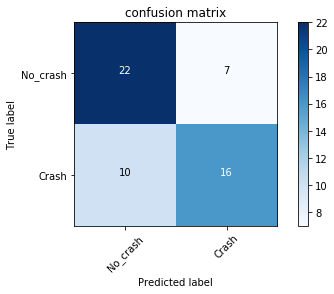

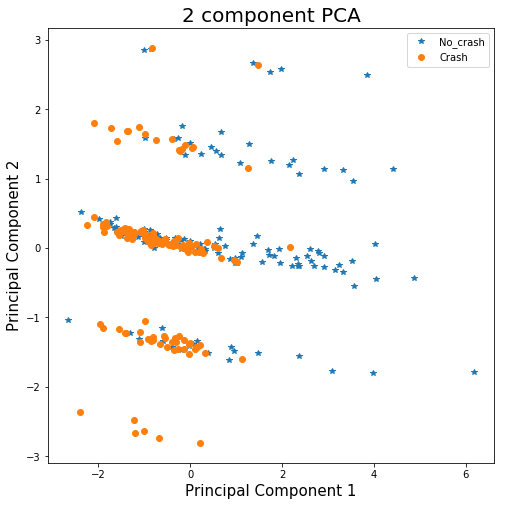

In [7]:
clf = LogisticRegression(penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Support Vector Machine Learning Model to predict crash and no crash risk

Training Accuracy Score:  0.6818181818181818
validation Accuracy Score: 0.7454545454545455
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.70      0.90      0.79        29
      Crash       0.83      0.58      0.68        26

avg / total       0.76      0.75      0.74        55

Confusion matrix, without normalization
[[26  3]
 [11 15]]


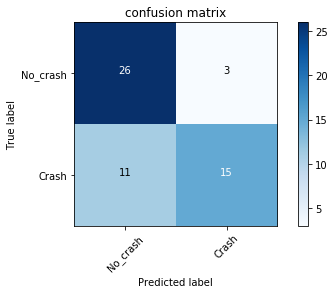

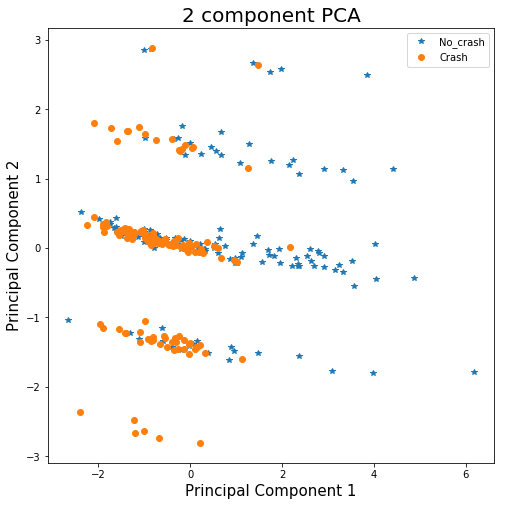

In [8]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065, 0.01], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [9]:
clf.best_estimator_

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
# After Training 105 (3, 5, 7) Different model for the best parameter search. We Found a model which does generalizes
# with the validation data and does not suffer from over fitting. The Current SVM model acheives 2 percent better 
# model performance.

#  Random Forest Based Machine Learning Models


Training Accuracy Score:  0.8045454545454546
validation Accuracy Score: 0.6
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.67      0.48      0.56        29
      Crash       0.56      0.73      0.63        26

avg / total       0.62      0.60      0.59        55

Confusion matrix, without normalization
[[14 15]
 [ 7 19]]


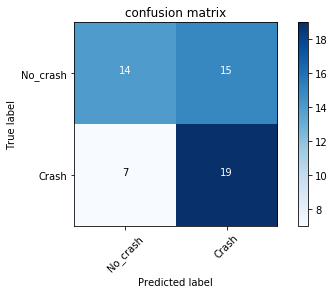

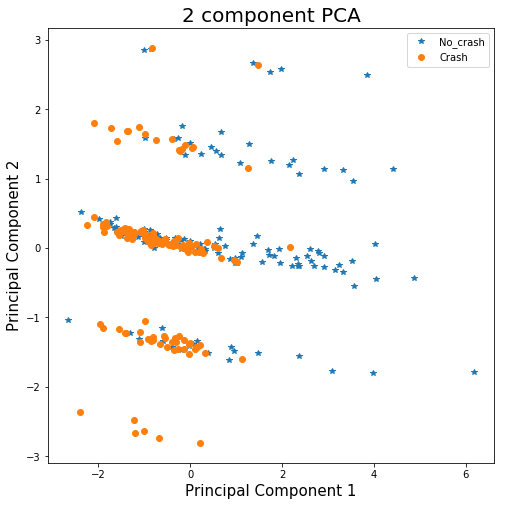

In [11]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [12]:
# Filling na values with the mean of the variable
# Normalizing the data

filledData = data.where(pd.notna(data), data.mean(), axis='columns')
#filledData = (filledData - filledData.mean())/filledData.std()

# Getting the crash Status
y = leftTurn["crashStatus"]

# Crash and near crash as one field 
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))

from sklearn.feature_selection import SelectKBest,f_classif
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8, random_state=42)



est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

Number of crashs events:  140.0
Class Balance with Crash and no Crash:  0.509090909090909
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     87.58
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           1.81e-54
Time:                        10:03:44   Log-Likelihood:                -164.85
No. Observations:                 275   AIC:                             339.7
Df Residuals:                     270   BIC:                             357.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

# Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

In [13]:
leftTurn = pd.read_excel("leftturn.xlsx")

# removing the near crash files.
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash'] 

data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  35.0
Class Balance with Crash and Baseline Condition:  0.20588235294117646


Training Accuracy Score:  0.8813559322033898
validation Accuracy Score: 0.7692307692307693
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.76      1.00      0.86        38
      Crash       1.00      0.14      0.25        14

avg / total       0.82      0.77      0.70        52

Confusion matrix, without normalization
[[38  0]
 [12  2]]


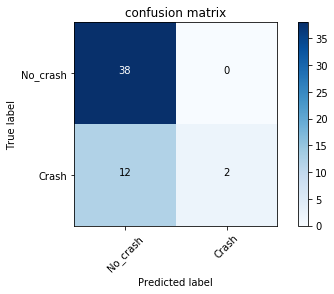

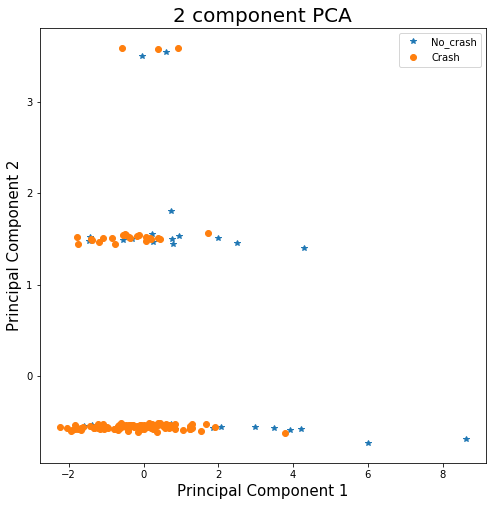

In [14]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.8728813559322034
validation Accuracy Score: 0.7692307692307693
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.76      1.00      0.86        38
      Crash       1.00      0.14      0.25        14

avg / total       0.82      0.77      0.70        52

Confusion matrix, without normalization
[[38  0]
 [12  2]]


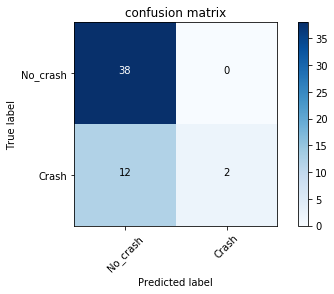

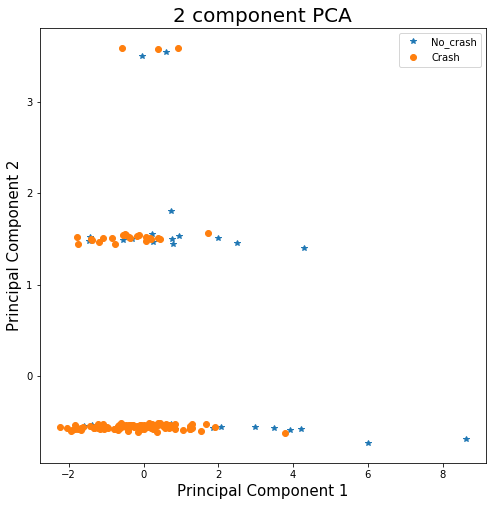

In [15]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.9576271186440678
validation Accuracy Score: 0.7692307692307693
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.76      1.00      0.86        38
      Crash       1.00      0.14      0.25        14

avg / total       0.82      0.77      0.70        52

Confusion matrix, without normalization
[[38  0]
 [12  2]]


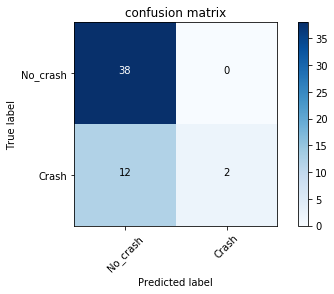

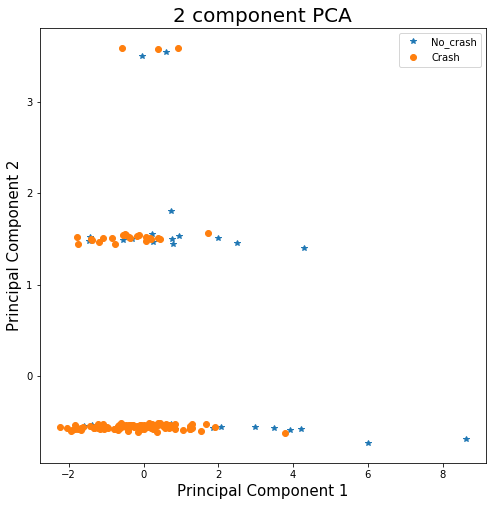

In [16]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [17]:
leftTurn = pd.read_excel("leftturn.xlsx")

# removing the near crash files.
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash'] 

data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
#filledData = (filledData - filledData.mean())/filledData.std()
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)



est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

Number of crashs events:  35.0
Class Balance with Crash and Baseline Condition:  0.20588235294117646
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     22.64
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           2.94e-17
Time:                        10:04:21   Log-Likelihood:                -62.476
No. Observations:                 170   AIC:                             135.0
Df Residuals:                     165   BIC:                             150.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------

# Predicting if the driver is young or old from their driving data all 275 data used


In [18]:
leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus"], axis = 1)

filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()
y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)
filledData = filledData.drop(["age"], axis =1)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of old drivers:  172.0
Class Balance with old drivers and young driver:  0.6254545454545455


Training Accuracy Score:  0.6354166666666666
validation Accuracy Score: 0.6506024096385542
Classification Report: 
             precision    recall  f1-score   support

      Young       1.00      0.09      0.17        32
        Old       0.64      1.00      0.78        51

avg / total       0.78      0.65      0.54        83

Confusion matrix, without normalization
[[ 3 29]
 [ 0 51]]


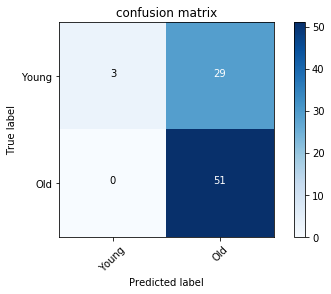

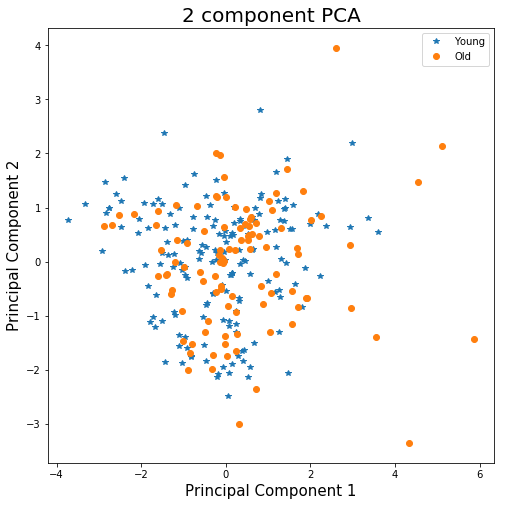

In [19]:
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
Predicting if the driver is young or old from their driving data all 275 data used¶

Training Accuracy Score:  0.6666666666666666
validation Accuracy Score: 0.6144578313253012
Classification Report: 
             precision    recall  f1-score   support

      Young       0.50      0.03      0.06        32
        Old       0.62      0.98      0.76        51

avg / total       0.57      0.61      0.49        83

Confusion matrix, without normalization
[[ 1 31]
 [ 1 50]]


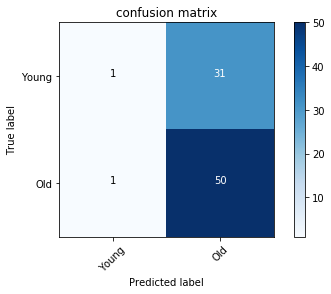

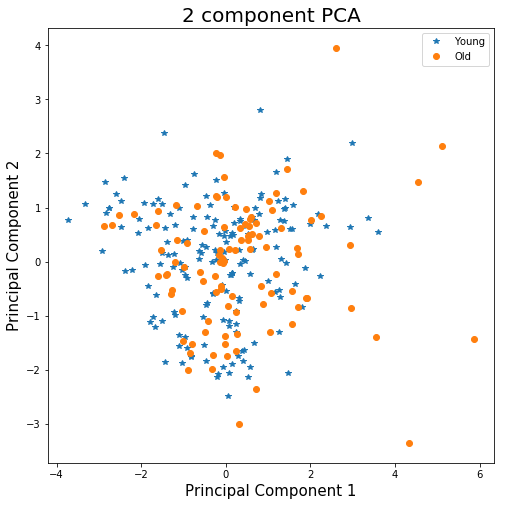

In [20]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.9947916666666666
validation Accuracy Score: 0.6144578313253012
Classification Report: 
             precision    recall  f1-score   support

      Young       0.50      0.28      0.36        32
        Old       0.65      0.82      0.72        51

avg / total       0.59      0.61      0.58        83

Confusion matrix, without normalization
[[ 9 23]
 [ 9 42]]


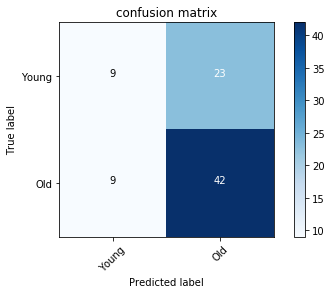

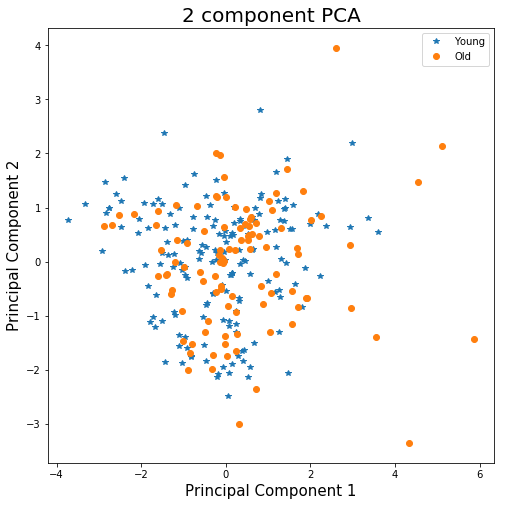

In [21]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [22]:
leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus"], axis = 1)

filledData = data.where(pd.notna(data), data.mean(), axis='columns')
#filledData = (filledData - filledData.mean())/filledData.std()
y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)
filledData = filledData.drop(["age"], axis =1)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

Number of old drivers:  172.0
Class Balance with old drivers and young driver:  0.6254545454545455
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     81.73
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           5.13e-52
Time:                        10:05:01   Log-Likelihood:                -198.95
No. Observations:                 275   AIC:                             407.9
Df Residuals:                     270   BIC:                             426.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------

# Model to predict old driver at risk of crash or not

In [23]:
leftTurn = pd.read_excel("leftturn.xlsx")

old_crash = leftTurn[(leftTurn["age"]>=65) & ((leftTurn["crashStatus"]=="Crash"))]
old_baseline = leftTurn[(leftTurn["age"]>=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:30]
leftTurn = pd.concat([old_crash, old_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/(filledData.std()+1e-4)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  23.0
Class Balance with Crash and Baseline Condition:  0.4339622641509434


Training Accuracy Score:  0.8108108108108109
validation Accuracy Score: 0.5625
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.50      1.00      0.67         7
   Old drivers at risk       1.00      0.22      0.36         9

           avg / total       0.78      0.56      0.50        16

Confusion matrix, without normalization
[[7 0]
 [7 2]]


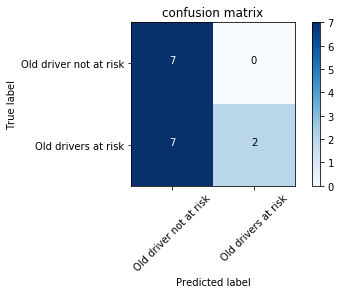

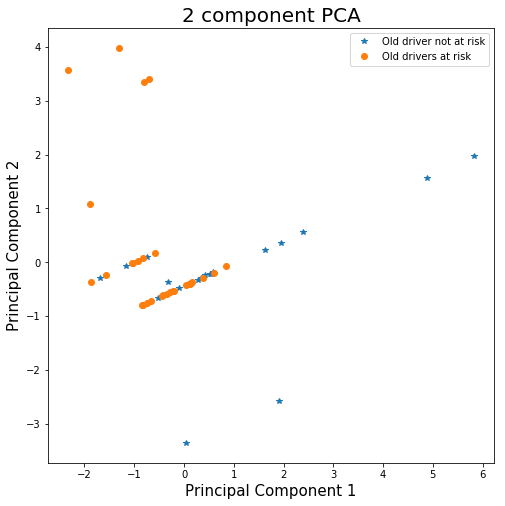

In [24]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict old driver at risk of crash or not:

Training Accuracy Score:  0.7837837837837838
validation Accuracy Score: 0.5
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.47      1.00      0.64         7
   Old drivers at risk       1.00      0.11      0.20         9

           avg / total       0.77      0.50      0.39        16

Confusion matrix, without normalization
[[7 0]
 [8 1]]


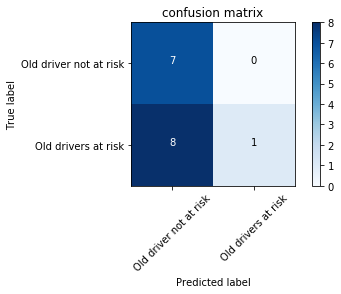

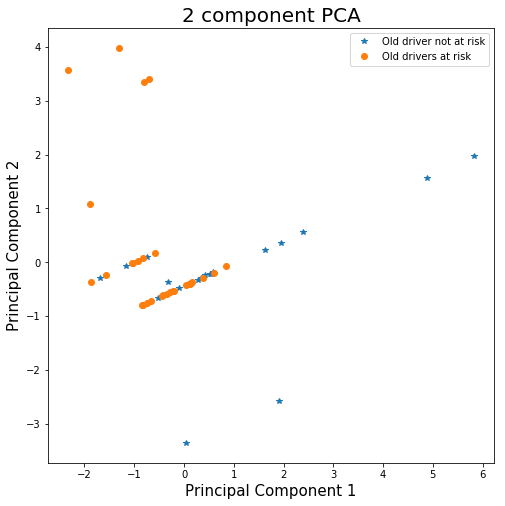

In [25]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    predict old driver at risk of crash or not:


Training Accuracy Score:  1.0
validation Accuracy Score: 0.5625
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.50      0.86      0.63         7
   Old drivers at risk       0.75      0.33      0.46         9

           avg / total       0.64      0.56      0.54        16

Confusion matrix, without normalization
[[6 1]
 [6 3]]


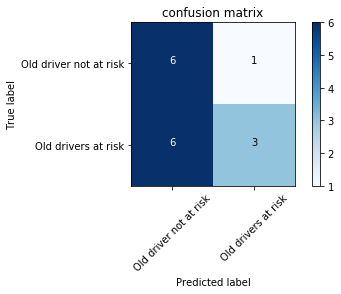

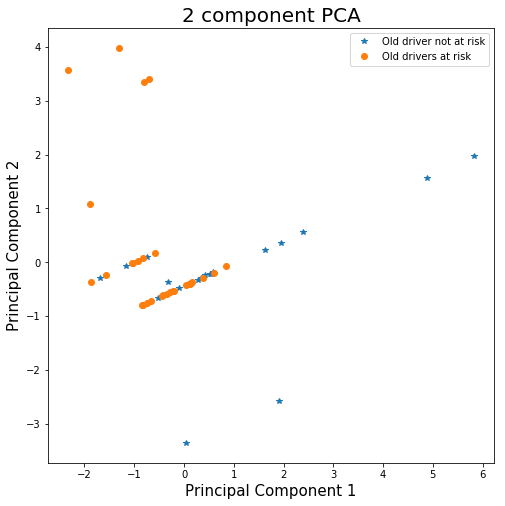

In [26]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [27]:
leftTurn = pd.read_excel("leftturn.xlsx")

old_crash = leftTurn[(leftTurn["age"]>=65) & ((leftTurn["crashStatus"]=="Crash"))]
old_baseline = leftTurn[(leftTurn["age"]>=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:30]
leftTurn = pd.concat([old_crash, old_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
#filledData = (filledData - filledData.mean())/(filledData.std()+1e-4)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

Number of crashs events:  23.0
Class Balance with Crash and Baseline Condition:  0.4339622641509434
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     12.44
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           9.18e-08
Time:                        10:05:38   Log-Likelihood:                -31.053
No. Observations:                  53   AIC:                             72.11
Df Residuals:                      48   BIC:                             81.96
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------

# drivers 65 or less at the crash risk or not

In [28]:
leftTurn = pd.read_excel("leftturn.xlsx")

young_crash = leftTurn[(leftTurn["age"]<=65) & ((leftTurn["crashStatus"]=="Crash"))]
young_baseline = leftTurn[(leftTurn["age"]<=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:20]
leftTurn = pd.concat([young_crash, young_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/(filledData.std()+1e-8)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  10.0
Class Balance with Crash and Baseline Condition:  0.3333333333333333


Training Accuracy Score:  0.8095238095238095
validation Accuracy Score: 0.6666666666666666
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.75      0.86      0.80         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.58      0.67      0.62         9

Confusion matrix, without normalization
[[6 1]
 [2 0]]


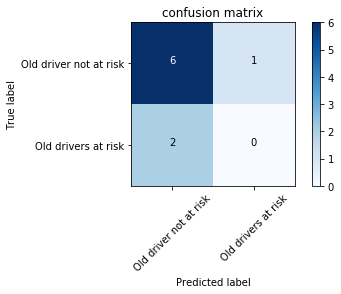

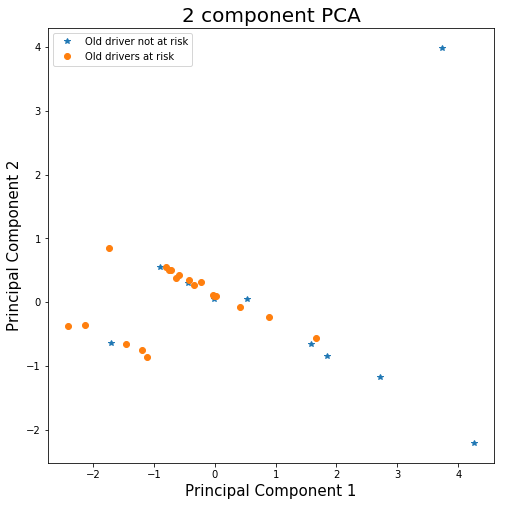

In [29]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict drivers 65 or less at the crash risk or not¶


Training Accuracy Score:  0.8571428571428571
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


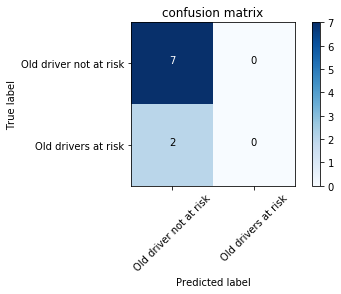

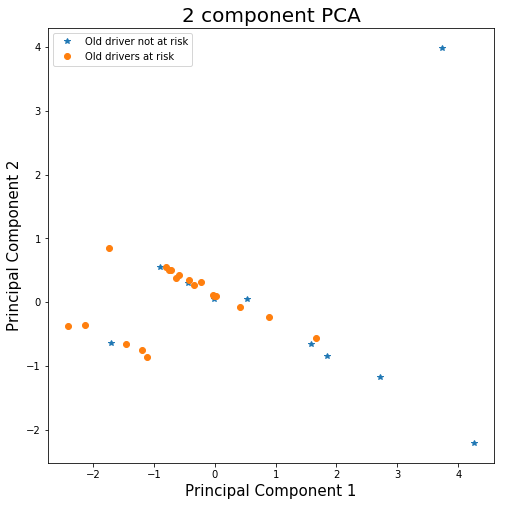

In [30]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
drivers 65 or less at the crash risk or not¶¶

Training Accuracy Score:  1.0
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


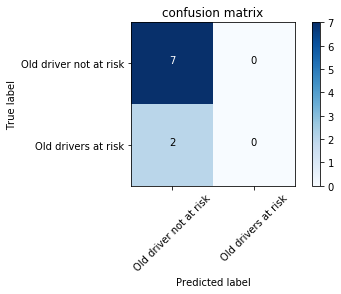

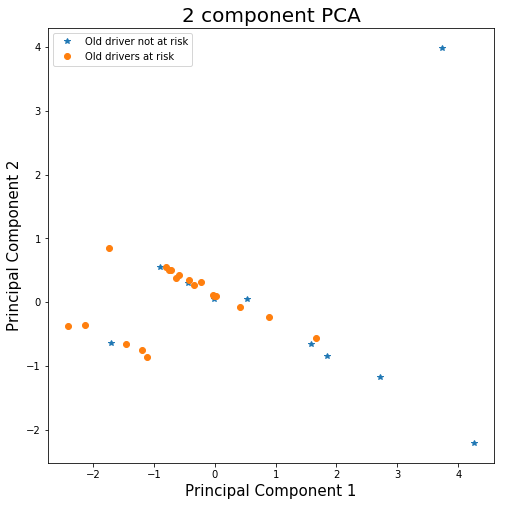

In [31]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [32]:
leftTurn = pd.read_excel("leftturn.xlsx")

young_crash = leftTurn[(leftTurn["age"]<=65) & ((leftTurn["crashStatus"]=="Crash"))]
young_baseline = leftTurn[(leftTurn["age"]<=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:20]
leftTurn = pd.concat([young_crash, young_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
#filledData = (filledData - filledData.mean())/(filledData.std()+1e-8)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

Number of crashs events:  10.0
Class Balance with Crash and Baseline Condition:  0.3333333333333333
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     5.825
Date:                Wed, 19 Sep 2018   Prob (F-statistic):            0.00106
Time:                        10:06:14   Log-Likelihood:                -14.502
No. Observations:                  30   AIC:                             39.00
Df Residuals:                      25   BIC:                             46.01
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------